# 6주차 스터디 

    1. 시계열 데이터 다루기 
    
    2. 주성분분석 (PCA)

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

## 1. 시계열 데이터 다루기 

누락값처리 / 샘플링

### 1-1) 누락된 시계열 데이터 생성하고, 채워보기

* Forward Fill
* Moving average
* Interpolation

In [2]:
#파일을 불러올 떄, 처음부터 parse_dates=리스트 형태로 주어줘서 datetime으로 가져올 수 있다(위치숫자로도 줄 수 있음)
un_rate = pd.read_excel("실업률.xlsx", parse_dates=["Year"],
                        index_col=0)
un_rate.index = un_rate.index.to_period()  # datetime 형태를 period로 바꿔 주면, 1977,1978 형태로 나타낼 수 있군
un_rate

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.2,7.0,7.2,6.9,7.0,6.8,6.8,6.8,6.4
1978,6.4,6.3,6.3,6.1,6.0,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.6,5.7,5.7,6.0,5.9,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.9,7.5,7.6,7.8,7.7,7.5,7.5,7.5,7.2


In [3]:
# 임으로 데이터를 누락한 데이터셋과 가장 높은 실업률을 기록한 달을 누락한 데이터셋을 분리해보자
random_df = un_rate.copy() 

# 1. 임의로 누락
def change_random(x):
    x[np.random.randint(0,len(x))] = np.nan
    return x

random_df.apply(change_random, axis=1)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.2,7.0,7.2,6.9,7.0,6.8,6.8,6.8,NaN
1978,6.4,6.3,6.3,NaN,6.0,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.6,NaN,5.7,6.0,5.9,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.9,7.5,7.6,7.8,7.7,7.5,NaN,7.5,7.2


In [4]:
# 2. 가장 실업률이 높은 월을 누락
## 참조) df.apply(axis=1) 이면 Column wise하게 함수를 날린다
def change_high(x):
    x[np.argmax(x)] = np.nan
    return x

max_df = un_rate.copy()
max_df.apply(change_high, axis=1)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,NaN,7.4,7.2,7.0,7.2,6.9,7.0,6.8,6.8,6.8,6.4
1978,NaN,6.3,6.3,6.1,6.0,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.6,5.7,5.7,NaN,5.9,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.9,7.5,7.6,NaN,7.7,7.5,7.5,7.5,7.2


Text(0.5, 0, 'Year')

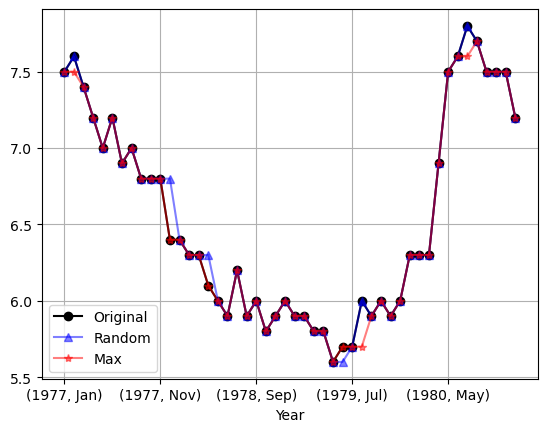

In [5]:
# 포워드필 -> 이전의 관측값으로 단순히 NaN 값을 채운다

# random_sample
random_df_ffill = random_df.stack(dropna=False).ffill()

# max_sample
max_df_ffill = max_df.stack(dropna=False).ffill()

# Plot으로 그려보자
un_rate.stack().plot(c="k", marker="o", label="Original")
random_df_ffill.plot(c='b', marker="^", label="Random", alpha=0.5)
max_df_ffill.plot(c="r", marker="*", label="Max", alpha=0.5)
plt.legend()
plt.grid()
plt.xlabel("Year")

In [6]:
# 이동평균 -> 노이즈가 많은 데이터인 경우 포워드필 보다는 이동평균을 사용해야 한다(평균은 노이즈의 일부를 제거할 수 있다)
random_stack = random_df.stack(dropna=False)
random_stack_rolling = random_stack.rolling(3, min_periods=1).mean()

pd.concat([random_stack, random_stack_rolling], axis=1, keys=["Original","Rolling Mean"])[:12]

Original  Rolling Mean
Year                            
1977 Jan       7.5      7.500000
     Feb       7.6      7.550000
     Mar       7.4      7.500000
     Apr       7.2      7.400000
     May       7.0      7.200000
     Jun       7.2      7.133333
     Jul       6.9      7.033333
     Aug       7.0      7.033333
     Sep       6.8      6.900000
     Oct       6.8      6.866667
     Nov       6.8      6.800000
     Dec       NaN      6.800000

In [7]:
# random_sample 데이터프레임의 NaN 값을 rolling 값으로 교체. 
# rolling().mean()은 NaN이 있는 경우 NaN을 리턴하기 때문에, min_periods=1로 설정
random_stack.fillna(random_stack.rolling(3, min_periods=1).mean()).unstack()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.2,7.0,7.2,6.9,7.0,6.8,6.8,6.8,6.8
1978,6.4,6.3,6.3,6.3,6.0,5.9,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.6,5.7,5.7,6.0,5.9,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.9,7.5,7.6,7.8,7.7,7.5,7.6,7.5,7.2


In [8]:
# 이동평균 (지수평균)
random_stack.fillna(random_stack.rolling(3, min_periods=1, win_type="exponential").mean()).unstack()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.2,7.0,7.200000,6.9,7.0,6.8,6.800000,6.8,6.8
1978,6.4,6.3,6.3,6.3,6.0,5.900000,6.2,5.9,6.0,5.800000,5.9,6.0
1979,5.9,5.9,5.8,5.8,5.6,5.653788,5.7,6.0,5.9,6.000000,5.9,6.0
1980,6.3,6.3,6.3,6.9,7.5,7.600000,7.8,7.7,7.5,7.553788,7.5,7.2


In [9]:
# 보간법
## 누락된 값을 대치할 때, 이미 알고 있는 지식에 기반하여 특정한 경향을 사용하게끔 제한할 수 있다. -> 시간에 따라 시스템이 동작하는 방식을 알고 있고, 그 지식을 활용할 때 특히 유용한 방식이다

random_stack.interpolate("linear").unstack()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
1977,7.5,7.6,7.4,7.20,7.0,7.20,6.9,7.0,6.8,6.8,6.8,6.6
1978,6.4,6.3,6.3,6.15,6.0,5.90,6.2,5.9,6.0,5.8,5.9,6.0
1979,5.9,5.9,5.8,5.80,5.6,5.65,5.7,6.0,5.9,6.0,5.9,6.0
1980,6.3,6.3,6.3,6.90,7.5,7.60,7.8,7.7,7.5,7.5,7.5,7.2


### 1-2) 샘플링

* 다운샘플링: 데이터의 빈도를 줄인다

* 업샘플링 : 데이터의 빈도를 늘린다 (Not Free Lunch -> 더 많은 시간 레이블을 얻을 수는 있지만, 더 많은 정보가 추가되는 것은 아니다)


* 판다스의 resample을 사용할 수 있다

In [10]:
# 다운 샘플링 예시) 시계열의 1월 부분에만 집중하는 경우
un_rate_stack = un_rate.copy().stack()

# 1월달 인덱스를 불리안으로 가져오기
jan_idx = un_rate_stack.index.get_level_values(1) == "Jan"

# 1월달 값만 추출하기 -> 1월달만 가져올 수 있다!!!
un_rate_stack[jan_idx]

Year     
1977  Jan    7.5
1978  Jan    6.4
1979  Jan    5.9
1980  Jan    6.3
dtype: float64

### 1-3) 데이터 평활

In [11]:
# 데이터 불러오기
air = pd.read_csv("https://raw.githubusercontent.com/PracticalTimeSeriesAnalysis/BookRepo/master/Ch02/data/AirPassengers.csv",
                  names=['Date', 'Passengers'], index_col=0, parse_dates=True)
air.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [12]:
# 지수평활 
air["EWM_0.5"] = air.Passengers.ewm(alpha=0.5).mean()
air["EWM_0.9"] = air.Passengers.ewm(alpha=0.9).mean()
air.head()

,Passengers,EWM_0.5,EWM_0.9
Date,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,116.000000,117.454545
1949-03-01,132,125.142857,130.558559
1949-04-01,129,127.200000,129.155716
1949-05-01,121,124.000000,121.815498


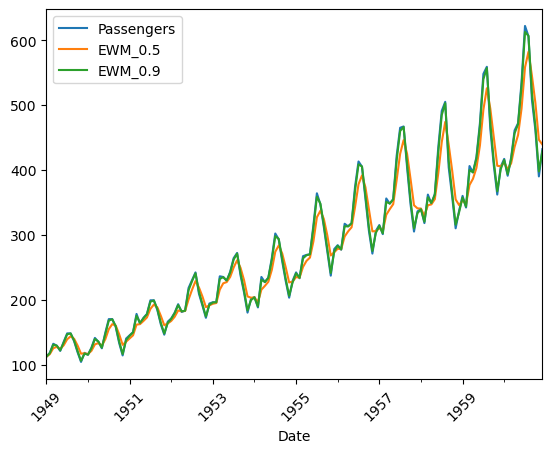

In [13]:
air.plot()
plt.xticks(rotation=45);

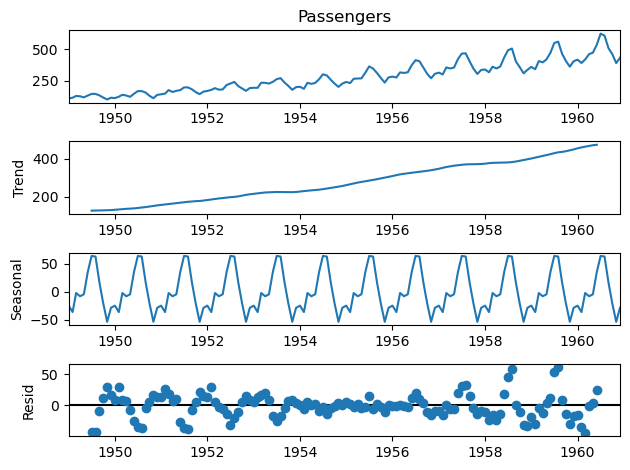

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(air.Passengers, model='additive')
result.plot(); # ; 을 안주니 plot을 두개를 출력하는군...

In [15]:
result.trend[10:20]  #  trend, seasonal, resid  출력가능   

Date
1949-11-01    129.000000
1949-12-01    129.750000
1950-01-01    131.250000
1950-02-01    133.083333
1950-03-01    134.916667
1950-04-01    136.416667
1950-05-01    137.416667
1950-06-01    138.750000
1950-07-01    140.916667
1950-08-01    143.166667
Name: trend, dtype: float64

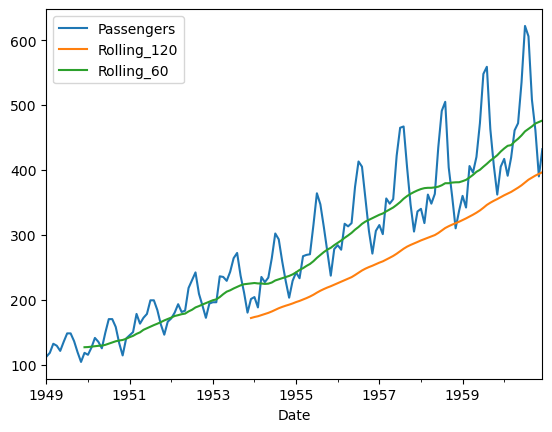

In [16]:
air["Rolling_120"] = air.Passengers.rolling(window=60).mean()
air["Rolling_60"] = air.Passengers.rolling(window=12).mean()

air[["Passengers","Rolling_120","Rolling_60"]].plot();

## 2. 주성분분석(PCA)

차원축소의 기법 중 하나

데이터의 분산을 최대한 보존하는 방향으로 데이터의 차원을 축소함

In [17]:
# 3차원 데이터 생성
m = 1000
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

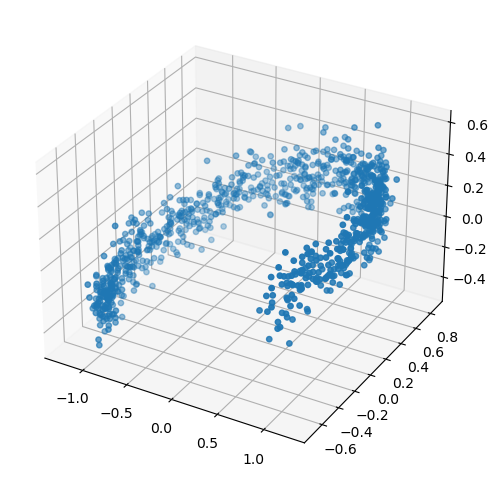

In [18]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], marker='o', s=15);

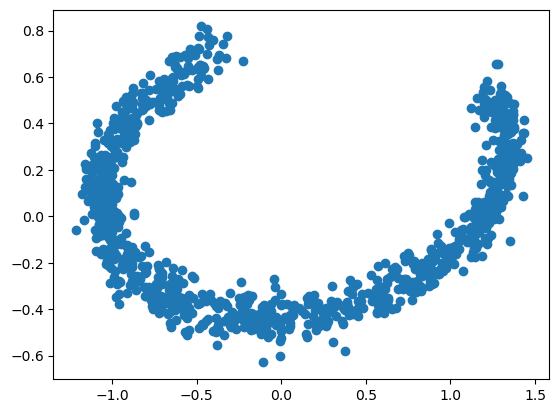

In [19]:
from sklearn.decomposition import PCA

# 두개의 차원으로 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1]);

In [20]:
pca.explained_variance_ratio_ , sum(pca.explained_variance_ratio_)

(array([0.86268919, 0.12713677]), 0.9898259523703461)

PCA를 사용한 모델 학습

In [21]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [22]:
pca = PCA(n_components=0.95) # 분산의 95%를 보전
X_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [23]:
# 그냥 학습하는 경우 (최적화의 기본개념 + 로지스틱 회귀란?)
import time
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs")
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

# 걸린시간 출력
print(t1-t0)

8.248904466629028


c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [24]:
# 정확도 확인
log_clf.score(X_test, y_test)

0.9197714285714286

In [25]:
# PCA로 차원을 줄인 데이터로 학습할 경우
log_clf_pca = LogisticRegression(multi_class="multinomial", solver="lbfgs")

t0 = time.time()
log_clf_pca.fit(X_reduced, y_train)
t1 = time.time()

# 걸린시간 출력
print(t1-t0)

5.187961101531982


c:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
# PCA로 차원을 축소시킨 모형의 정확도 확인
log_clf_pca.score(X_test_reduced, y_test)

0.9162857142857143